# Problem Description

Egyptian Ratscrew is a fun game. It basically goes like this: deal a deck of cards among your friends, face down. Then, taking turns, each person pops a card from their delt stack and places it face up onto an intially empty pile. If someone places a royal onto the pile, then the next player is _CHALLENGED_. They must pop 1 card for a Jack, 2 for a Queen, 3 for a King, and 4 for an Ace; after which, the challenger gets to put the pile upside-down under their stack. The goal, is to be the last person with a non-empty stack. However, if someone who is challened pops a royal, then they cease popping cards and become the new challenger! Now, the most interesting quirk is that a player can slap the pile whenever the same face appears twice in a row, or appears as the bread in a 3 card sandwich. And anyone can slap in anytime, even if they have no cards left!

# Some Questions

Here are some questions we wish to be able to answer:

  1. How likely is it that one can de-challenge a royal, where there are no slaps?
  1. How does making those distributions different effect the distribution on the  number of turns?
  1. Does the distribution of turns look the same no matter what distributions you choose for the player response times?
  1. How strong is the correlation between "fast" response distribution and chance of winning?
  1. If the number of turns follows a power distribution, what statistics are useful for describing how long a game will take?
  1. What's a useful "norm" on those distributions?

# Modeling the Game

We could model the response times on players, but that seems like too much complexity. What we really care about is the probability that someone wins. That is it's much more straightforward to look use some multinomial distribution, then it is to give each player a new distribution each turn.

In [13]:
from collections import namedtuple
from itertools import chain

Card = namedtuple('Card', ['face', 'suite'])
royal = {'Jack': 1, 'Queen': 2, 'King': 3, 'Ace': 4}


def new_deck():
    cards = []
    for face in chain(range(2, 10 + 1), royal):
        for suite in ('Clubs', 'Diamonds', 'Hearts', 'Spades'):
            card = Card(face, suite)
            cards.append(card)
    return cards


assert len(new_deck()) == 52

In [4]:
from random import shuffle
from collections import deque


def deal(deck, num_players):
    """
    Shuffle a deck, and deal its cards equally amoung `num_players` hands.

    Args:
        deck: List[Card]
        num_players: int > 0

    Returns:
        List[collections.deque]
    """
    shuffle(deck)

    # Since we add the pile to the bottomfdasf  
    hands = [deque() for _ in range(num_players)]                     

    for hand in cycle(hands):
        if not deck:
            return hands
        new_card = deck.pop()
        hand.append(new_card)

    return hands

In [14]:
def slappable(pile):
    if len(pile) > 1 and pile[-1].face == pile[-2].face:
        return True
    if len(pile) > 2 and pile[-1].face == pile[-3].face:
        return True
    return False


assert not slappable([])

for card in new_deck():
    assert not slappable([card])

assert slappable([Card('Queen', 'Diamonds'), Card('Queen', 'Hearts')])
assert slappable([Card(2, 'Spades'), Card(2, 'Clubs')])

assert not slappable([Card('Queen', 'Diamonds'), Card('King', 'Hearts')])
assert not slappable([Card(2, 'Spades'), Card(3, 'Clubs')])

assert slappable([Card('Queen', 'Diamonds'), Card(2, 'Spades'), Card('Queen', 'Hearts')])
assert slappable([Card(2, 'Spades'), Card('Queen', 'Diamonds'), Card(2, 'Clubs')])

assert not slappable([Card('Queen', 'Diamonds'), Card(2, 'Spades'), Card('King', 'Hearts')])
assert not slappable([Card(2, 'Spades'), Card('Queen', 'Diamonds'), Card(3, 'Clubs')])

In [68]:
from itertools import cycle
import logging

logger = logging.getLogger(__name__)

# import random
# np.random.seed(42)
# random.seed(42)

def simulate_game(num_players, slap):
    deck = new_deck()
    hands = deal(deck, num_players)  # hands are stacks (cards face down)
    pile = []                        # pile is a stack (cards face up)
    chances = 0  # number of chances for current challenged player
    challenger = None  # index of player who played royal card

    for turn, hand_index in enumerate(cycle(range(num_players)), start=1):            
        hand = hands[hand_index]
        
        logger.info('{} {} {}'.format(
            [len(hand) for hand in hands],
            chances,
            [card.face for card in pile]
        ))

        if sum(len(hand) > 0 for hand in hands) == 1:
            return turn, np.argmax([len(h) for h in hands])
        if not hand:
            continue

        if challenger is None:
            new_card = hand.pop()
            pile.append(new_card)
            logger.info('player {} drew a {}'.format(hand_index, new_card.face))
            if new_card.face in royal:
                challenger = hand_index
                chances = royal[new_card.face]
        else:
            while chances > 0 and hand:
                new_card = hand.pop()
                logger.info('player {} drew a {}'.format(hand_index, new_card.face))
                pile.append(new_card)
                chances -= 1

                # A player can slap the pile even if a royal was placed.
                if slappable(pile):
                    slapper = slap()
                    logger.info('player {} slapped'.format(slapper))
                    hands[slapper].extendleft(reversed(pile))
                    pile.clear()
                    chances = 0
                    break

                # Break out of challenged if royal is placed.
                if new_card.face in royal:
                    challenger = hand_index
                    chances = royal[new_card.face]
                    break

            if chances == 0:
                hands[challenger].extendleft(reversed(pile))
                pile.clear()
                challenger = None

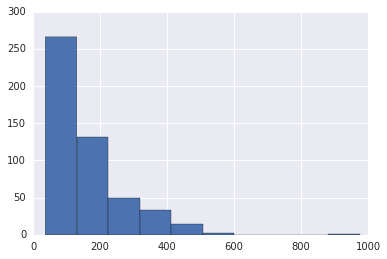

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline


num_players = 2

# def slap():
#     return np.argmax(np.random.multinomial(1, [1/num_players]*num_players))

def slap():
    return np.argmax(np.random.multinomial(1, [0.2, 0.8]))
    

turns = [simulate_game(num_players, slap)[0] for _ in range(500)]
plt.hist(turns)
plt.show()

In [9]:
from scipy.stats import describe

num_simulations = 100
num_players = 2

turns = [simulate_game(num_players, .1) for _ in range(num_simulations)]
turns = [t for t in turns if t is not None]
describe(turns)

DescribeResult(nobs=100, minmax=(array([36,  0]), array([1285,    1])), mean=array([ 166.93,    0.45]), variance=array([  2.57588738e+04,   2.50000000e-01]), skewness=array([ 3.94719938,  0.20100756]), kurtosis=array([ 22.39139182,  -1.95959596]))